In [1]:
#hivemind.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#3 March 2018
#
#This illustrates how to play the hivemind game...

In [2]:
#game settings
N_buckets = 5
N_turns = 500
rn_seed = 14

In [3]:
#generate game data
from hivemind import *
bucket_yields, best_bucket, bucket_yield_mean, bucket_yield_sigma = play_hivemind(N_buckets, N_turns)
print bucket_yields[0]
print best_bucket[0]

[ 0.          0.05041298  0.20232085  0.75949557 -0.23071912]
[ 0.  0.  0.  1.  0.]


In [4]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

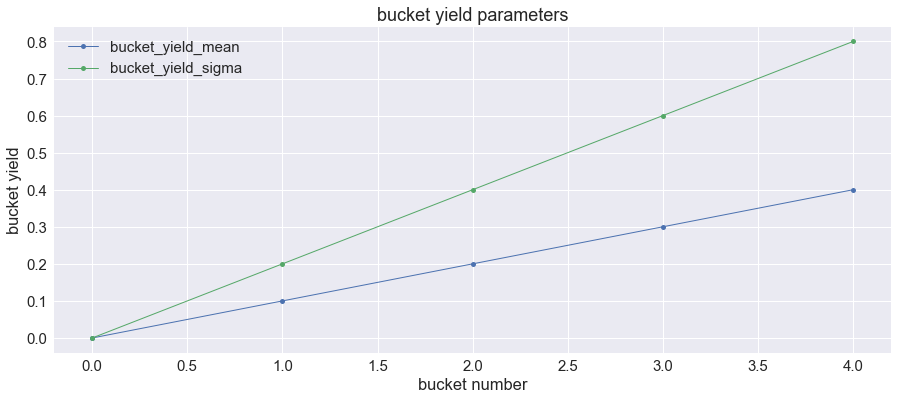

In [5]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = np.arange(N_buckets)
yp = bucket_yield_mean
ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label='bucket_yield_mean')
yp = bucket_yield_sigma
ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label='bucket_yield_sigma')
ax.set_title('bucket yield parameters')
ax.set_ylabel('bucket yield')
ax.set_xlabel('bucket number')
ax.legend()

In [6]:
#test-train-validation split is 1:1:1
train_fraction = 1.0/3.0
x = bucket_yields
y = best_bucket
from sklearn.model_selection import train_test_split
x_train, x_test_validate, y_train, y_test_validate = train_test_split(x, y, train_size=train_fraction, 
    test_size=(1-train_fraction), random_state=rn_seed)
train_fraction = 0.5
x_test, x_validate, y_test, y_validate = \
    train_test_split(x_test_validate, y_test_validate, train_size=train_fraction, random_state=rn_seed)
print x.shape, y.shape
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape
print x_validate.shape, y_validate.shape

(500, 5) (500, 5)
(166, 5) (166, 5)
(167, 5) (167, 5)
(167, 5) (167, 5)


/Users/joe/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
#build MLP classification model 
N_inputs = x.shape[1]
N_outputs = y.shape[1]
N_middle_layer = (N_inputs + N_outputs)/2
dropout_fraction = 0.25
model = mlp_classifier(N_inputs, N_middle_layer, N_outputs, dropout_fraction)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________


In [8]:
#train model to predict rewards
N_epochs = 200
batch_size = N_turns/100
dropout_fraction = 0.13
N_middle_layer = (N_inputs + N_outputs)/2
print 'layers = ', N_inputs, N_middle_layer, N_outputs
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(N_inputs, N_middle_layer, N_outputs, dropout_fraction)
fit_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=N_epochs, verbose=0, 
    validation_data=(x_validate, y_validate))

layers =  5 5 5
dropout_fraction =  0.13


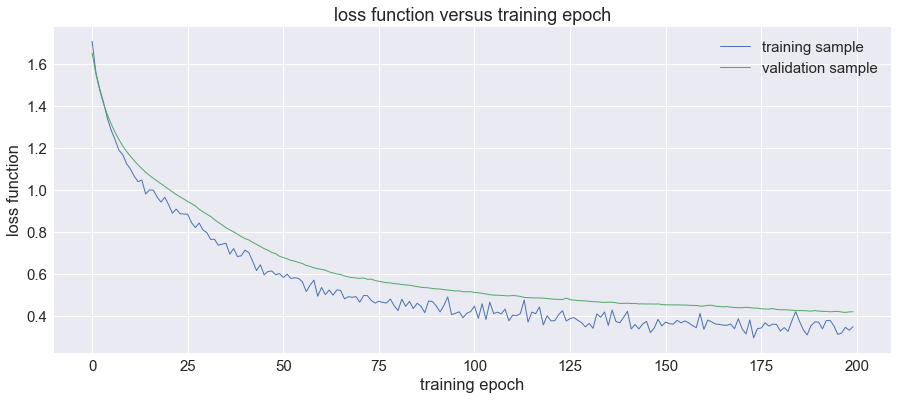

In [9]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, linewidth=1, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, linewidth=1, label='validation sample')
ax.set_title('loss function versus training epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()

In [10]:
#play short game and use trained model to predict best_bucket_probability
N_turns = 10
bucket_yields, best_bucket, bucket_yield_mean, bucket_yield_sigma = play_hivemind(N_buckets, N_turns)
best_bucket_probability = model.predict(bucket_yields)
print 'bucket_yields:'
print bucket_yields
print 'best_bucket_probability:'
print best_bucket_probability

bucket_yields:
[[ 0.          0.10076909  0.40065786 -0.05313639 -0.86566399]
 [ 0.          0.07436259  0.08193089  0.06774074  1.16233423]
 [ 0.          0.14345006  0.26133204  0.9552903  -0.49643716]
 [ 0.         -0.19861835  0.29793338  0.78690285 -0.56858661]
 [ 0.         -0.01548025  1.34575798  1.3255973   0.42500956]
 [ 0.          0.26861494  0.52419349  0.47618188 -0.11521715]
 [ 0.          0.13924887  0.01222071 -0.46466765  0.60439954]
 [ 0.          0.06073047 -0.01596776  0.70321196  0.03412811]
 [ 0.          0.06845773  0.39513158  1.32633095 -0.60850578]
 [ 0.          0.43935886  0.12966745  0.56347767 -0.62467654]]
best_bucket_probability:
[[  1.17652526e-05   2.58689195e-01   7.37291753e-01   4.00726125e-03
    3.27460214e-09]
 [  1.35346781e-05   2.47632735e-04   1.50788145e-03   4.49165673e-05
    9.98186052e-01]
 [  9.40428254e-06   4.98753507e-03   9.88551509e-03   9.85117435e-01
    3.25802354e-08]
 [  1.76332760e-05   6.82312343e-03   1.25777787e-02   9.80

In [11]:
#compute ...
net_yields = compute_net_yields(bucket_yields, best_bucket_probability)
net_yields

,yield0,yield1,yield2,yield3,yield4,prob0,prob1,prob2,prob3,prob4,net
0,0.0,0.100769,0.400658,-0.053136,-0.865664,1.176525e-05,0.258689,0.737292,0.004007,3.274602e-09,0.321257
1,0.0,0.074363,0.081931,0.067741,1.162334,1.353468e-05,0.000248,0.001508,0.000045,9.981861e-01,1.160371
2,0.0,0.143450,0.261332,0.955290,-0.496437,9.404283e-06,0.004988,0.009886,0.985117,3.258024e-08,0.944372
3,0.0,-0.198618,0.297933,0.786903,-0.568587,1.763328e-05,0.006823,0.012578,0.980581,1.166526e-07,0.774014
4,0.0,-0.015480,1.345758,1.325597,0.425010,1.657719e-06,0.001210,0.018961,0.979825,2.047189e-06,1.324352
5,0.0,0.268615,0.524193,0.476182,-0.115217,2.004347e-04,0.178838,0.481463,0.339490,9.215821e-06,0.462076
6,0.0,0.139249,0.012221,-0.464668,0.604400,6.707118e-05,0.007416,0.029095,0.000004,9.634186e-01,0.583676
7,0.0,0.060730,-0.015968,0.703212,0.034128,1.569419e-04,0.002423,0.003396,0.993735,2.885087e-04,0.698909
8,0.0,0.068458,0.395132,1.326331,-0.608506,9.850520e-07,0.001423,0.004794,0.993782,1.153825e-09,1.320076
9,0.0,0.439359,0.129667,0.563478,-0.624677,9.124289e-05,0.117367,0.128667,0.753875,2.673575e-08,0.493042


In [ ]:
#generate dataframe of yields, probabilities, and net 
cols = ['yield'+str(idx) for idx in range(N_buckets)]
import pandas as pd
net_yields = pd.DataFrame(bucket_yields, columns=cols)
net_yields['net'] = 0.0
#best_bucket_probability = model.predict(bucket_yields)
for idx in range(N_buckets):
    prob_col = 'prob'+str(idx)
    net_yields[prob_col] = best_bucket_probability[:, idx]
    yield_col = 'yield'+str(idx)
    net_yields['net'] += net_yields[yield_col]*net_yields[prob_col]
cols = [col for col in net_yields.columns if (col != 'net')] + ['net']
net_yields = net_yields[cols]
net_yields.head()

In [ ]:
##show that the predicted value=mean of actuals
#agg_dict = {'y_test':['count', 'mean', 'std'], 'y_test_pred':['mean']}
#test_grouped = test.groupby(cols, as_index=False).agg(agg_dict)
#test_grouped

In [ ]:
##plot y_test_pred vs p0
#df = test_grouped
#xp = df['y_test']['mean']
#yp = df['y_test_pred']['mean']
#fig, ax = plt.subplots(1,1, figsize=(15, 6))
#p = ax.plot(xp, yp, marker='o', markersize=5, linewidth=1, label='y_test_pred')
#p = ax.plot(p0, p0, linewidth=1, label='p0')
#p = ax.set_ylabel('y_test_pred')
#p = ax.set_xlabel('y_test')
#p = ax.legend()